In [46]:
import pandas as pd
import numpy as np
from scipy.cluster.vq import kmeans,vq,whiten

In [47]:
df = pd.read_csv('HealthViz County Dataset 6 21 17.csv', skiprows=0, header=1, index_col=0, encoding = "ISO-8859-1")
df.index.name=None

In [48]:
df.dropna(axis=0, how='any', inplace=True)
df.drop(df.columns[[0]], axis=1, inplace=True) #drop 'County'

In [49]:
def split_df(df, num, col_population):
    '''
    Split dataframe into desired number of groups based on the population
        num: int
        col_population: string, e.g 'Population (residents), 2011-2015'
        
        return: a list of sub dataframes
    '''
    rows, cols = df.shape
    size = int(round(rows/num, 0))
    df = df.sort_values(col_population, ascending=True)
    l = []
    for g, df in df.groupby(np.arange(len(df)) // size):
        l = l + [df]
    if len(l) > num:
        df1 = l[-1]
        df2 = l[-2]
        df3 = df2.append(df1)
        l = l[: -2]
        l = l + [df3]
    return l


In [50]:
# for check
l = split_df(df, 10, 'Population (residents), 2011-2015')
for i in l:
    print(i.shape)

(248, 17)
(248, 17)
(248, 17)
(248, 17)
(248, 17)
(248, 17)
(248, 17)
(248, 17)
(248, 17)
(250, 17)


In [51]:
# elbow effect to choose K in K-means
# sum of squared error (SSE): sum of the squared distance between each member of the cluster and its centroid

# Get K function
def get_k(df, size):
    '''
    Using the size of each cluster to determine the number of clusters, which is K
        size: int
    '''
    rows, cols = df.shape
    k = int(round(rows/size, 0))
    return k


from scipy.cluster.vq import kmeans,vq,whiten
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

def check_k(df, k, graph_range):
    '''
    range(1, 100)
    '''
    a,b = graph_range
    K = range(a,b)
    X = whiten(df)
    KM = [kmeans(X,k) for k in K]
    centroids = [cent for (cent,var) in KM]
    D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
    #cIdx = [np.argmin(D,axis=1) for D in D_k]
    dist = [np.min(D,axis=1) for D in D_k]
    avgWithinSS = [sum(d)/X.shape[0] for d in dist]
    l = []
    for i in range(a-1, b-2):
        rate = abs(avgWithinSS[i+1] - avgWithinSS[i])/avgWithinSS[i]
        l = l + [rate]
    k_changing_rate = l[k-2]
    
    kIdx = k-1
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
        markeredgewidth=2, markeredgecolor='r', markerfacecolor='None') #K[kIdx] [kIdx]
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()
    
    return k_changing_rate

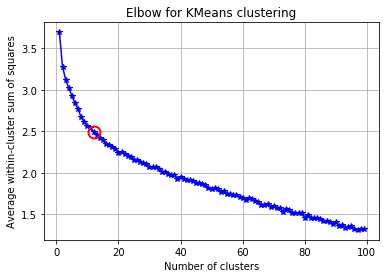

0.01451624959654485

In [52]:
df1 = l[0]
k = get_k(df1, 20)
graph_range = (1,100)
check_k(df1, k, graph_range)

In [53]:
# get the clustering table
from sklearn.cluster import KMeans
import numpy as np
def get_k_means(df,k):
    X = whiten(df)
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    df['label'] = kmeans.labels_.tolist()
    return df

In [54]:
ddf = get_k_means(df1, k)

In [55]:
ddf.groupby('label').size()

label
0     16
1      1
2     11
3     40
4     46
5     13
6     41
7     42
8     16
9      6
10    12
11     4
dtype: int64